### import

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font",family='Kai')
plt.rcParams['axes.unicode_minus'] =False
from pyqpanda import *
from scipy.integrate import solve_ivp
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

### Lorenz63

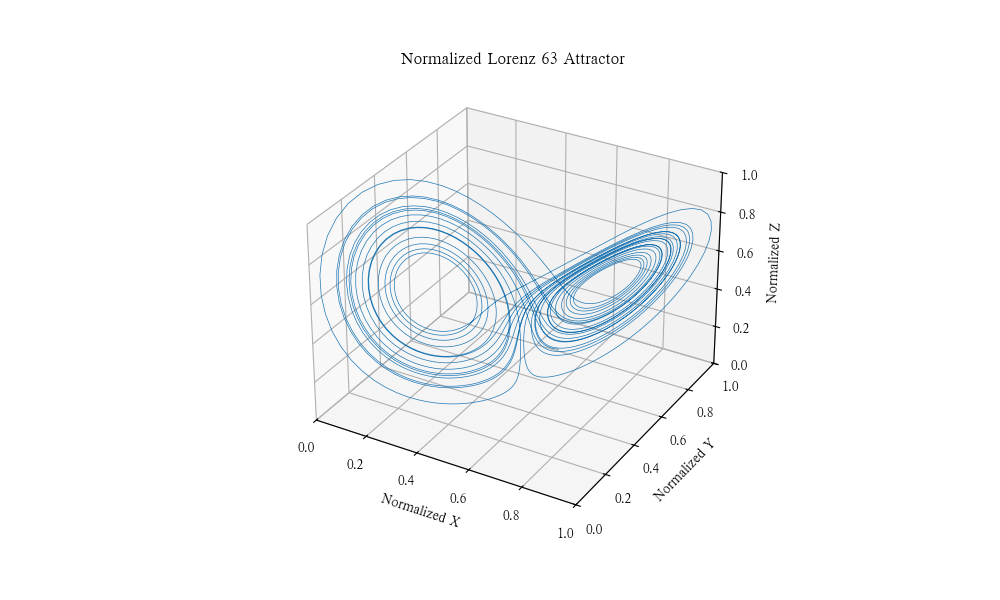

In [38]:
def RK45(x, func, h):
    """四阶龙格-库塔积分器"""
    K1 = func(x)
    K2 = func(x + h/2*K1)
    K3 = func(x + h/2*K2)
    K4 = func(x + h*K3)
    return x + h/6*(K1 + 2*K2 + 2*K3 + K4)

def L63_rhs(x, sigma=10.0, rho=28.0, beta=8/3):
    """定义Lorenz 63微分方程"""
    dx = np.zeros(3)
    dx[0] = sigma * (x[1] - x[0])
    dx[1] = rho*x[0] - x[1] - x[0]*x[2]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

def integrate_lorenz63(x0, num_steps=2500, dt=0.01):
    """执行数值积分"""
    trajectory = np.zeros((num_steps, 3))
    trajectory[0] = x0
    for t in range(1, num_steps):
        trajectory[t] = RK45(trajectory[t-1], L63_rhs, dt)
    return trajectory

def normalize_trajectory(trajectory):
    """将轨迹归一化到[0, 1]范围"""
    # 计算每个坐标轴的极值
    mins = np.min(trajectory, axis=0)
    maxs = np.max(trajectory, axis=0)
    
    # 线性归一化公式：new = (original - min)/(max - min)
    normalized =(trajectory - mins) / (maxs - mins)
    return normalized

# 参数设置
x0 = np.array([1.508870, -1.531271, 25.46091])  # 混沌初值
traj = integrate_lorenz63(x0)

# 应用归一化
traj_normalized = normalize_trajectory(traj)

# 划分训练集和测试集
train_data = traj_normalized[:2000]
test_data = traj_normalized[2000:2500]

# 绘制归一化后的轨迹
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj_normalized[:,0], traj_normalized[:,1], traj_normalized[:,2], lw=0.5)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])
ax.set_xlabel("Normalized X")
ax.set_ylabel("Normalized Y")
ax.set_zlabel("Normalized Z")
plt.title("Normalized Lorenz 63 Attractor")
plt.show()


### 8-qubit machine

In [39]:
### 8-qubit machine
# 在循环开始前初始化列表
all_sorted_values = []
# 对于8个量子比特，可能的状态总数是2^8=256
n_states = 256
# 初始化256个参数
params = [0.5*np.pi] * 256 
# 存储量子线路的输出结果
quantum_outputs = []
# 初始化上一次的概率值为None
prev_sorted_values = None
#参数\varepsilon
varepsilon = 0.05
#量子线路概率输入的层数
ccc = 32
#q、c比特数量 shot
n_qubits = 8
n_cbits = 8
shots = 10000
# 参数设置 
beta_range = (0,2*np.pi ) 
# β参数的均匀分布范围 # 生成输入数据 (示例) 
np.random.seed (42) 
xt = np.random.rand (n_qubits) # 输入向量 x_t (假设为4维) 
# 初始化随机β参数 (可复现) 
beta = np.random.uniform (*beta_range,n_qubits)
print(beta)

[3.77691701 4.44895122 0.12933619 6.09412333 5.23039137 1.33416598
 1.14243996 1.15236452]


In [40]:
for i in range(2000):
    if i % 1000 == 0:
        print(f"处理训练数据: {i}/2000")
 
    if i > 0 and len(all_sorted_values) > 0:
       # 使用上一次的sorted_values更新参数
       prev_values = all_sorted_values[-1]
       for j in range(min(len(prev_values), 256)):
           params[j] = prev_values[j] *4*np.pi

    x_norm, y_norm, z_norm = 4*np.pi*traj_normalized[i]
    
    # 初始化量子虚拟机
    qvm = CPUQVM()
    qvm.init_qvm()
    n_qubits = 8
    n_cbits = 8

    # 分配量子比特和经典比特
    qubits = qvm.qAlloc_many(n_qubits)
    cbits = qvm.cAlloc_many(n_cbits)
    # 构建量子程序
    prog = QProg()
    circuit = QCircuit()
    # 使用256个参数构建电路
    param_index = 0
    for layer in range(ccc):  # 32层，每层使用8个参数
        for qubit in range(8):
            circuit << RY(qubits[qubit], params[param_index])
            param_index += 1
            if qubit < 7:
                circuit << CNOT(qubits[qubit], qubits[qubit+1])
        circuit << CNOT(qubits[7], qubits[0])
    # 添加Lorenz坐标相关的门
    circuit << RY(qubits[0], x_norm) 
    circuit << CNOT(qubits[0], qubits[1]) 
    circuit << RY(qubits[1], y_norm) 
    circuit << CNOT(qubits[1], qubits[2]) 
    circuit << RY(qubits[2], z_norm)
    circuit << CNOT(qubits[2], qubits[3])
    circuit << CNOT(qubits[3], qubits[4])
    circuit << CNOT(qubits[4], qubits[5])
    circuit << CNOT(qubits[5], qubits[6])
    circuit << CNOT(qubits[6], qubits[7])
    circuit << CNOT(qubits[7], qubits[0]) 
    for qubit in range(8):
        circuit << RY(qubits[qubit], beta[qubit])
        if qubit < 7:
            circuit << CNOT(qubits[qubit], qubits[qubit+1])
    circuit << CNOT(qubits[7], qubits[0])
    prog << circuit << measure_all(qubits, cbits)
    # 运行多次量子程序，并返回测量结果
    result = qvm.run_with_configuration(prog, cbits, shots)
    # 计算概率分布
    total = shots
    probabilities = {}
    
    # 确保所有可能的状态都有值
    for state_idx in range(n_states):
        # 将索引转换为8位二进制字符串
        state = format(state_idx, '08b')
        # 如果状态在结果中，使用实际概率；否则为0
        probabilities[state] = round(result.get(state, 0) / total, 6)
    
    # 确保按照状态排序，而不是按照概率值排序
    sorted_states = sorted(probabilities.keys())
    raw_sorted_values = [probabilities[state] for state in sorted_states]
        
    # 非线性化处理：新概率 = 0.2*当前概率 + 0.8*上一次概率
    if i > 0 and prev_values is not None:
        sorted_values = [0] * len(raw_sorted_values)
        for j in range(len(raw_sorted_values)):
            sorted_values[j] = round(varepsilon * raw_sorted_values[j] + (1 - varepsilon) * prev_values[j], 6)
    else:
        sorted_values = raw_sorted_values.copy()

    all_sorted_values.append(sorted_values)
    quantum_outputs.append(sorted_values)
    print("概率值：", raw_sorted_values[:256])

    qvm.finalize()



处理训练数据: 0/2000
概率值： [0.0002, 0.0151, 0.0, 0.0, 0.0031, 0.0177, 0.0, 0.0, 0.0, 0.0, 0.0016, 0.0215, 0.0, 0.0, 0.0023, 0.0, 0.0032, 0.0539, 0.0, 0.0, 0.0012, 0.0, 0.0, 0.0004, 0.0, 0.0004, 0.0001, 0.0067, 0.0, 0.0002, 0.0072, 0.0381, 0.0137, 0.0008, 0.0, 0.0, 0.0005, 0.0, 0.0002, 0.0, 0.0002, 0.0, 0.0088, 0.0025, 0.0, 0.0, 0.0257, 0.0007, 0.0025, 0.0004, 0.0004, 0.0, 0.0637, 0.0039, 0.0, 0.0, 0.0004, 0.0, 0.0319, 0.0016, 0.0003, 0.0001, 0.0002, 0.0, 0.0009, 0.0018, 0.0, 0.0, 0.0018, 0.0101, 0.0, 0.0003, 0.0, 0.0, 0.002, 0.0338, 0.0, 0.0002, 0.0004, 0.0045, 0.0006, 0.0123, 0.0, 0.0, 0.0001, 0.0093, 0.0, 0.0004, 0.0, 0.0, 0.0017, 0.0035, 0.0, 0.0, 0.0009, 0.0049, 0.0186, 0.0034, 0.0, 0.0, 0.0062, 0.0001, 0.0003, 0.0001, 0.0, 0.0, 0.0003, 0.0, 0.0, 0.0, 0.0182, 0.0001, 0.0008, 0.0002, 0.0, 0.0, 0.0084, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0056, 0.0019, 0.0006, 0.0001, 0.0125, 0.003, 0.0045, 0.0008, 0.0003, 0.0001, 0.0367, 0.0081, 0.0008, 0.0, 0.0002, 0.0, 0.0473, 0.0056, 0.0002, 0.0, 0.0003, 0.000

In [41]:
# 准备训练数据
X_train = []
y_train = []

# 使用量子输出和当前坐标预测下一个时间步的坐标
for i in range(1999):
    # 特征：当前量子输出 + 当前坐标
    features = quantum_outputs[i] #+list(train_data[i])
    # 目标：下一个时间步的坐标
    target = train_data[i+1]
    X_train.append(features)
    y_train.append(target)

X_train = np.array(X_train)
y_train = np.array(y_train)

# 训练岭回归模型
ridge = Ridge(alpha=0.0001)
ridge.fit(X_train, y_train)
print("岭回归模型训练完成")

# 测试阶段：预测2001-2501时间步
predictions = []
current_state = train_data[-1]  # 从训练集最后一个状态开始
current_quantum_output = quantum_outputs[-1]  # 最后一个量子输出

# 初始化预测阶段的上一次概率值
prev_pred_values = current_quantum_output.copy()

岭回归模型训练完成


In [42]:
for i in range(500):
    if i % 100 == 0:
        print(f"预测测试数据: {i}/500")
    
    # 特征：当前量子输出 + 当前坐标
    features = current_quantum_output #+ list(current_state)
    for j in range(min(len(features), 256)):
           params[j] = features[j] *4*np.pi
    # 预测下一个状态
    next_state = ridge.predict([features])[0]
    predictions.append(next_state)
    
    # 更新当前状态为预测的状态
    current_state = next_state

    # 使用预测的状态生成新的量子输出
    x_norm, y_norm, z_norm = 4*np.pi*current_state
    
    # 初始化量子虚拟机
    qvm = CPUQVM()
    qvm.init_qvm()
    qubits = qvm.qAlloc_many(n_qubits)
    cbits = qvm.cAlloc_many(n_cbits)

    # 构建量子程序
    prog = QProg()
    circuit = QCircuit()
    param_index = 0
    for layer in range(ccc): 
        for qubit in range(8):
            circuit << RY(qubits[qubit], params[param_index])
            param_index += 1
            if qubit < 7:
                circuit << CNOT(qubits[qubit], qubits[qubit+1])
        circuit << CNOT(qubits[7], qubits[0]) 
    circuit << RY(qubits[0], x_norm) 
    circuit << CNOT(qubits[0], qubits[1]) 
    circuit << RY(qubits[1], y_norm) 
    circuit << CNOT(qubits[1], qubits[2]) 
    circuit << RY(qubits[2], z_norm)
    circuit << CNOT(qubits[2], qubits[3])
    circuit << CNOT(qubits[3], qubits[4])
    circuit << CNOT(qubits[4], qubits[5])
    circuit << CNOT(qubits[5], qubits[6])
    circuit << CNOT(qubits[6], qubits[7])
    circuit << CNOT(qubits[7], qubits[0]) 
    for qubit in range(8):
        circuit << RY(qubits[qubit], beta[qubit])
        if qubit < 7:
            circuit << CNOT(qubits[qubit], qubits[qubit+1])
    circuit << CNOT(qubits[7], qubits[0])
    prog << circuit << measure_all(qubits, cbits)
    result = qvm.run_with_configuration(prog, cbits, shots)

    # 计算概率分布
    probabilities = {}
    for state_idx in range(n_states):
        state = format(state_idx, '08b')
        probabilities[state] = round(result.get(state, 0) / shots, 6)
    
    sorted_states = sorted(probabilities.keys())
    raw_quantum_output = [probabilities[state] for state in sorted_states]
    
    # 对预测阶段的概率也进行非线性化处理
    current_quantum_output = []
    for j in range(len(raw_quantum_output)):
        new_prob = round(varepsilon * raw_quantum_output[j] + (1 - varepsilon) * prev_pred_values[j], 6)
        current_quantum_output.append(new_prob)
    # 更新上一次的概率值
    prev_pred_values=current_quantum_output.copy()

    qvm.finalize()
predictions = np.array(predictions)

print(predictions)


预测测试数据: 0/500
预测测试数据: 100/500
预测测试数据: 200/500
预测测试数据: 300/500
预测测试数据: 400/500
[[0.3868975  0.56725452 0.66578612]
 [0.41362611 0.58358308 0.65048565]
 [0.43531171 0.59610305 0.64217688]
 ...
 [0.10881779 0.26177263 0.17896529]
 [0.11049503 0.25436442 0.17882254]
 [0.10793591 0.24479751 0.19091214]]


测试集MSE: 0.14174610753129713


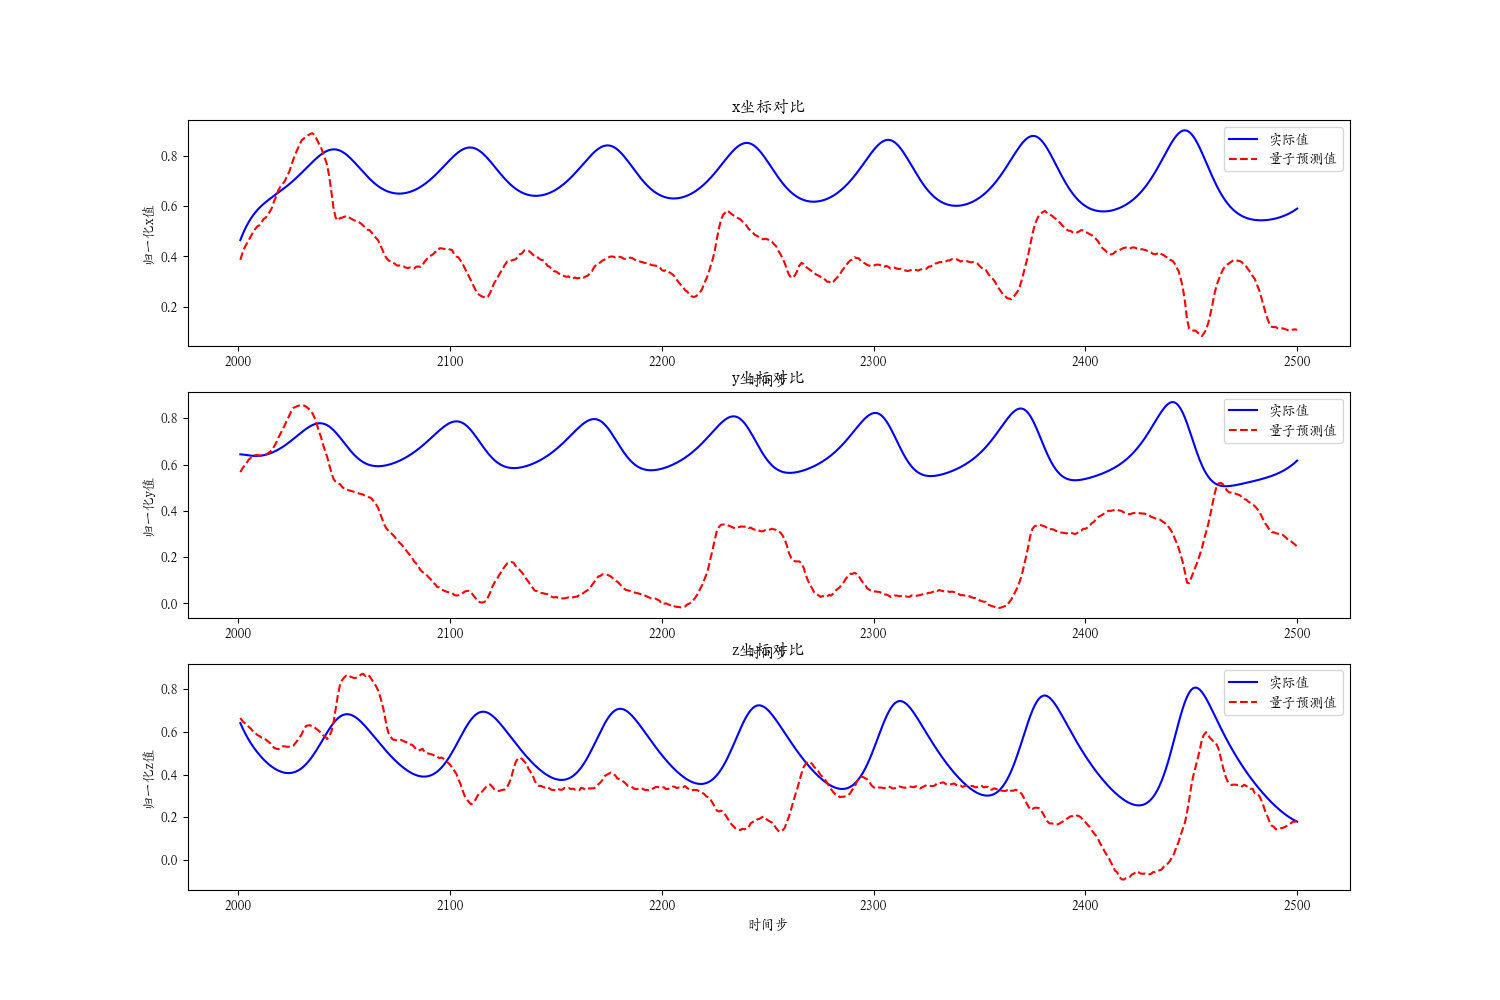

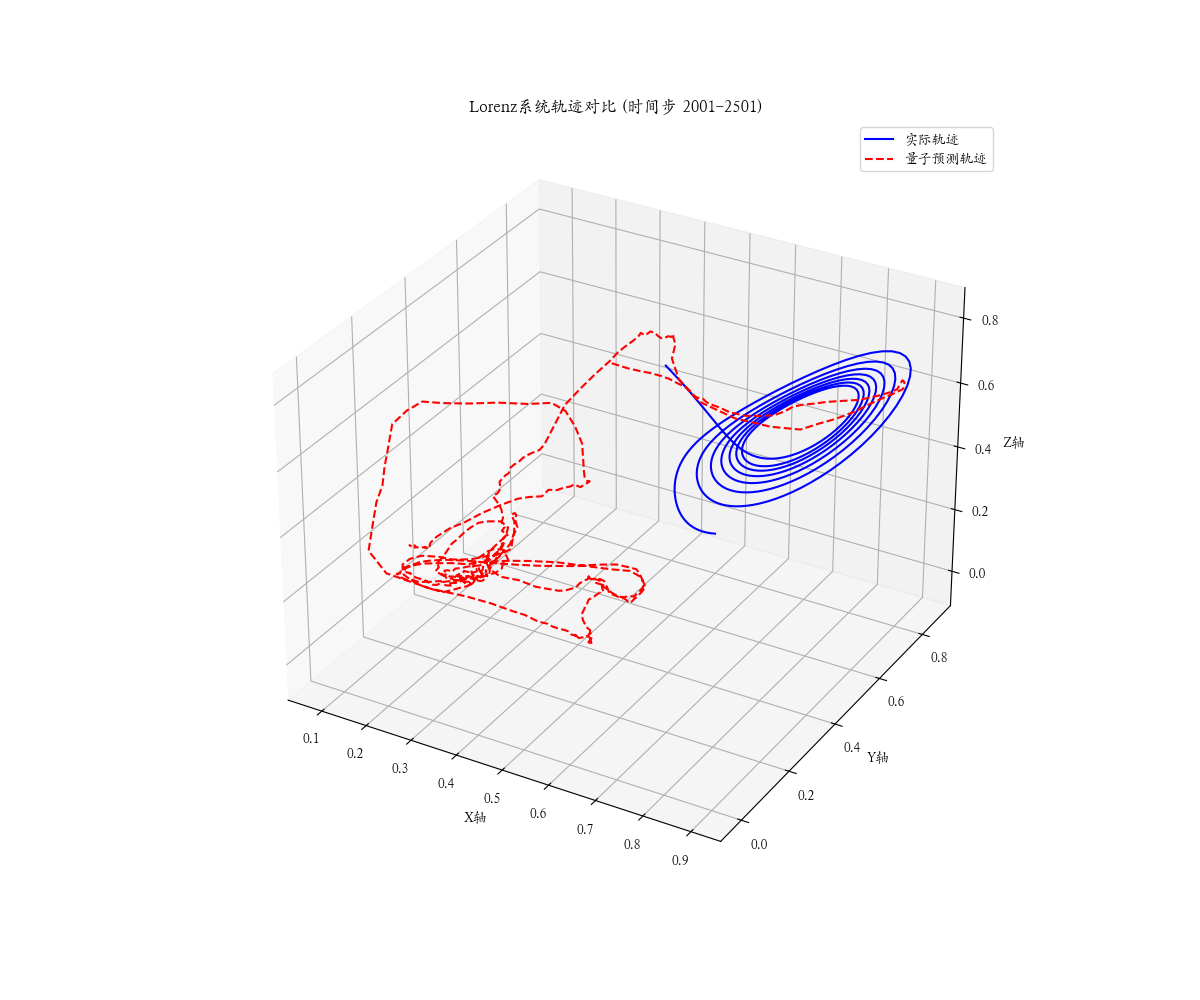

In [43]:
# 计算预测误差
mse = mean_squared_error(test_data, predictions)
print(f"测试集MSE: {mse}")

# 保存预测结果和实际值
np.save('/Users/dyy/github/QRC_project1/quantum_predictions.npy', predictions)
np.save('/Users/dyy/github/QRC_project1/actual_values.npy', test_data)

# 绘制对比图
fig = plt.figure(figsize=(15, 10))

# 绘制x坐标对比
ax1 = fig.add_subplot(311)
ax1.plot(range(2001, 2501), test_data[:, 0], 'b-', label='实际值')
ax1.plot(range(2001, 2501), predictions[:, 0], 'r--', label='量子预测值')
ax1.set_title('x坐标对比')
ax1.set_xlabel('时间步')
ax1.set_ylabel('归一化x值')
ax1.legend()

# 绘制y坐标对比
ax2 = fig.add_subplot(312)
ax2.plot(range(2001, 2501), test_data[:, 1], 'b-', label='实际值')
ax2.plot(range(2001, 2501), predictions[:, 1], 'r--', label='量子预测值')
ax2.set_title('y坐标对比')
ax2.set_xlabel('时间步')
ax2.set_ylabel('归一化y值')
ax2.legend()

# 绘制z坐标对比
ax3 = fig.add_subplot(313)
ax3.plot(range(2001, 2501), test_data[:, 2], 'b-', label='实际值')
ax3.plot(range(2001, 2501), predictions[:, 2], 'r--', label='量子预测值')
ax3.set_title('z坐标对比')
ax3.set_xlabel('时间步')
ax3.set_ylabel('归一化z值')
ax3.legend()
plt.savefig('/Users/dyy/github/QRC_project1/quantum_prediction_comparison.png')
plt.show()

# 绘制3D轨迹对比图
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# 绘制实际轨迹
ax.plot(test_data[:, 0], test_data[:, 1], test_data[:, 2], 'b-', label='实际轨迹')

# 绘制预测轨迹
ax.plot(predictions[:, 0], predictions[:, 1], predictions[:, 2], 'r--', label='量子预测轨迹')

ax.set_title('Lorenz系统轨迹对比 (时间步 2001-2501)')
ax.set_xlabel('X轴')
ax.set_ylabel('Y轴')
ax.set_zlabel('Z轴')
ax.legend()

plt.savefig('/Users/dyy/github/QRC_project1/quantum_3d_comparison.png')
plt.show()